# Relax Data Science Challenge

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption. We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [ ]:
#import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#read in csv files as pandas dataframes
users = pd.read_csv('takehome_users.csv',encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [ ]:
#Explore data
users.head()

In [ ]:
#explore data
users.info()

Note the missing values in last_session_creation_time and invited_by_user_id. Also note that all datetime columns are not of type datetime.

In [ ]:
#explore data
engagement.head()

In [ ]:
#explore data
engagement.info()

There don't appear to be any missing values in engagement. time_stamp is of type object and should be converted to datetime for further analysis.

## Identify Adopted Users

In [7]:
#convert time stamp to datetime
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [8]:
#extract week and year from time_stamp
engagement['week-year'] = engagement['time_stamp'].dt.strftime('%U-%Y')

In [9]:
#check dataframe
engagement.head()

,time_stamp,user_id,visited,week-year
0,2014-04-22 03:53:30,1,1,16-2014
1,2013-11-15 03:45:04,2,1,45-2013
2,2013-11-29 03:45:04,2,1,47-2013
3,2013-12-09 03:45:04,2,1,49-2013
4,2013-12-25 03:45:04,2,1,51-2013


In [10]:
#group by user and week and aggregate by count
usage = engagement.groupby(['user_id', 'week-year']).size().reset_index().rename(columns={0:'count'})

In [11]:
#if count is greater than or equal to 3, consider user to be an adopted user
usage['adopted'] = usage['count']>=3

In [12]:
#Extract list of adopted users
adopted_users = list(usage[usage.adopted==True].user_id.unique())

In [13]:
#add column in users df to identify adopted users. This is the target variable.
#if object_id is in the list of adopted users --> True. Else --> False.
users['adopted'] = users.object_id.apply(lambda x: x in adopted_users).astype(int)

## Drop Unnecessary Columns and Set Index

Since the object_id is the primary key, the name and email columns don't add any additional information that is useful for a prediction model. We can drop these columns and set object_id as the index.

In [14]:
#drop columns and set index
users_clean = users.drop(['name','email'],axis=1)
users_clean = users_clean.set_index('object_id')

In [15]:
users_clean.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


## Feature Engineering

Creation_source is a categorical variable that needs to be hot-encoded since most scikit-learn models only take numerical features as input.

In [16]:
#Look at the number of creation sources
users_clean.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [17]:
#One-hot encoding of creation_source. Drop first to avoid multicollinearity
source_dummies = pd.get_dummies(users_clean.creation_source,drop_first=True)
df = pd.concat([users_clean,source_dummies],axis=1)

#drop original column
df = df.drop(['creation_source'],axis=1)

In [38]:
#Convert creation_time and last_session_creation_time to datetime
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time,unit='s')

creation_month and last_session_creation_month are datetime columns that need to be converted to features. We can extract both month and year from these columns but multicollinearity analysis (not shown) showed that extracting both led to high variance inflation factors, indicating high multicollinearity. Therefore, we only extracted the month as the feature for both columns.

In [41]:
#Extract months from datetime columns.
df['creation_month'] = df.creation_time.dt.month

df['last_session_creation_month'] = df.last_session_creation_time.dt.month

invited_by_user_id has many null values, indicating the users that were not invited by any user_id. We will convert this column into a boolean variable to identify whether a user was invited by another user or not.

In [42]:
#convert invited by user_id to boolean
df['invited'] = df.invited_by_user_id.notnull().astype(int)

In [43]:
#drop redundant columns that have been converted to features
df = df.drop(['creation_time','last_session_creation_time','invited_by_user_id'],axis=1)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
opted_in_to_mailing_list       12000 non-null int64
enabled_for_marketing_drip     12000 non-null int64
org_id                         12000 non-null int64
adopted                        12000 non-null int64
ORG_INVITE                     12000 non-null uint8
PERSONAL_PROJECTS              12000 non-null uint8
SIGNUP                         12000 non-null uint8
SIGNUP_GOOGLE_AUTH             12000 non-null uint8
creation_month                 12000 non-null int64
last_session_creation_month    8823 non-null float64
invited                        12000 non-null int64
dtypes: float64(1), int64(6), uint8(4)
memory usage: 796.9 KB


last_session_creation_month has missing values and is of type float. Fill in the missing months as 0 and convert to type int.

In [46]:
df['last_session_creation_month'] = df['last_session_creation_month'].fillna(0).astype(int)

## What fraction of users were adopted?

11.9 % of observed users were adopted


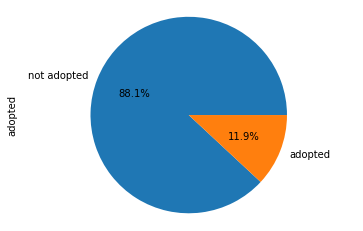

In [47]:
print(format(df.adopted.sum()/df.adopted.count()*100,'1.1f'), '% of observed users were adopted')
_ = df.adopted.value_counts().plot(kind='pie',labels=['not adopted','adopted'],autopct='%1.1f%%')
_ = plt.axis('equal')

Only 11.9% of users were adopted, showing a pretty significant class imbalance that will need to be addressed later! For now, we will split the data into X (features) and y (target) variables.

In [48]:
#Split data into X and y
X = df.drop(['adopted'],axis=1)
y = df['adopted']

## Final Multicollinearity Analysis

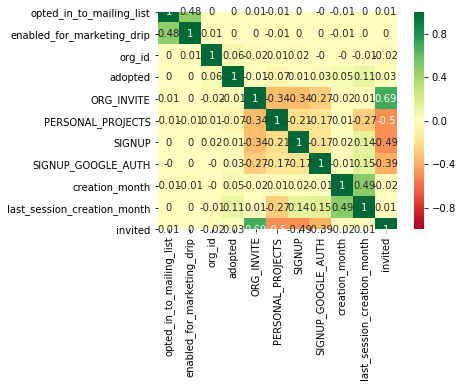

In [49]:
#Correlation matrix
_ = sns.heatmap(df.corr().round(2),square=True,annot=True,cmap='RdYlGn',vmin=-1, vmax=1)

The correlation matrix shows that last_session creation_month has the strongest direct, linear correation with adopted (0.22). None of the other columns have a correlation factor greater than 0.7 so no multicollinearity is evident from this matrix. We will not look at the variance inflation factors to confirm.

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Multicollinearity analysis
#Get features
feature_x = X
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
9,5.706871,invited
5,1.995989,SIGNUP
4,1.934526,PERSONAL_PROJECTS
3,1.915684,ORG_INVITE
6,1.655964,SIGNUP_GOOGLE_AUTH


Since all the VIFs are less than 10, it doesn't look like we have much multicollinearity present in our data. We're good to move forward with our machine learning model to identify the important features!

# Machine Learning

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [52]:
#Split data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

Remember the significant class imbalance that exists in our data, with only 11.9% of users being adopted? To combat this, we will oversample the training data to balance out the classes. Over-sampling will increase the number of adopted users in our data to (hopefully) close to a 50:50 ratio. To do this, we will use SMOTE (Synthetic Minority Over-Sampling Technique) which creates new (synthetic) observations based on the observations in our data.

In [54]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

[(0, 7398), (1, 7398)]


We will use compare a RandomForestClassifier and a GradientBoostingClassifier - both have built-in feature importance generators based on the Gini coefficients.

## Random Forest Classifier

In [55]:
%%time

from sklearn.ensemble import RandomForestClassifier

# instantiate model to run 50 estimators
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training set
cv_accuracy_rf = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5,scoring='f1')

# train model
rf.fit(X_train_resampled, y_train_resampled)

# predict on test data
y_pred_rf = rf.predict(X_test)

CPU times: user 2.18 s, sys: 46.3 ms, total: 2.23 s
Wall time: 2.29 s


In [56]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.95738
Test Accuracy: 0.94278
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         3047          123
Actual 1           83          347
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3170
           1       0.74      0.81      0.77       430

    accuracy                           0.94      3600
   macro avg       0.86      0.88      0.87      3600
weighted avg       0.95      0.94      0.94      3600



## Gradient Boosting Classifier

In [57]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

# instantiate model to run 50 estimators
gb = GradientBoostingClassifier(random_state=42)

#Cross-validate on training se=-809\p
cv_accuracy_gb = cross_val_score(gb, X_train_resampled, y_train_resampled, cv=5,scoring='f1')

# train model
gb.fit(X_train_resampled, y_train_resampled)

# predict on test data
y_pred_gb = gb.predict(X_test)

CPU times: user 3.84 s, sys: 50.3 ms, total: 3.89 s
Wall time: 4.02 s


In [58]:
print("Train Accuracy:",format(np.mean(cv_accuracy_gb),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_gb),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_gb),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_gb))

Train Accuracy: 0.94359
Test Accuracy: 0.94167
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         3026          144
Actual 1           66          364
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3170
           1       0.72      0.85      0.78       430

    accuracy                           0.94      3600
   macro avg       0.85      0.90      0.87      3600
weighted avg       0.95      0.94      0.94      3600



Both Random Forest and Gradient Boosting classifiers provide good training and test accuracies of about 94-95%. The f-1 score is 0.97 for the "not adopted" class and 0.78 for the "adopted class. The gradient boosting classifier results in slightly less overfitting and slightly higher f-1 score for the adopted class so we will use the GB model to determine feature importance.

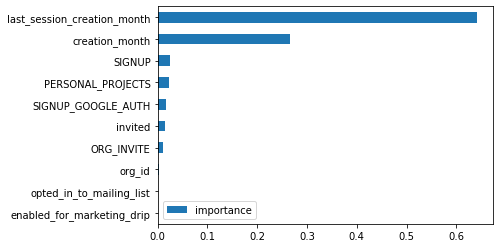

In [64]:
feature_importances = pd.DataFrame(gb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=True)

feature_importances.plot(kind='barh')

Based on the feature importance plot, we can see that the last_session_creation_month is the most important feature, followed by the creation_month. We can perform some EDA in order to better understand how the last_session_creation_month is correlated to adoption.

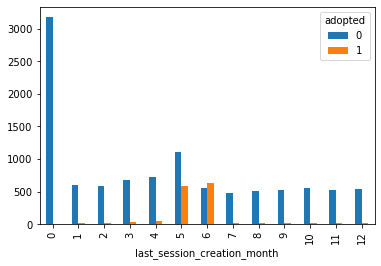

In [65]:
pd.crosstab(df.last_session_creation_month,df.adopted).plot(kind='bar')

We can see that, obviously, users who have not logged in within the past 2 years will not be considered adopted users and there are a significant number of users who have not logged in within the last 2 years. We would want to perform further analysis on this subset of users to better understand why they have not logged in. Most adopted users last logged in in May and June so I would want to understand what was done in May and June (any special deals etc.) that could have led to better user retention.